# Análisis de sentimientos

Vamos a importar librerías de utilidad.

In [1]:
# Import necessary libraries and modules
from pathlib import Path
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import TransformerMixin

from typing import List, Tuple, Dict, Optional, Any
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Funciones para cargar datos

In [2]:
def representation_to_document(document_representation: str) -> Tuple[str, str]:
    '''
    Convierte una representación del documento de un formato donde los términos se
    representan como parejas "palabra:conteo" en su forma plana y su etiqueta.

    Args:
        document_representation (str): La representación del documento donde los
        términos están en el formato "palabra:conteo", y la etiqueta es el último
        elemento.

    Returns:
        tuple: Una tupla con el texto plano del documento y su etiqueta.
    '''
    # Splitear cada pareja "palabra:conteo"
    word_counts = [term_representation.split(':') for term_representation in document_representation.split(' ')]
    
    # El label es el último elemento
    _, label = word_counts[-1]
    
    # Eliminar el label de los conteos de palabras
    word_counts = word_counts[:-1]
    
    # Reconstruir el documento al repetir cada palabra con base en su conteo
    words = []
    for term, count in word_counts:
        words.extend([term] * int(count))
    
    # Juntar las palabras en un solo string, y limpiar el label
    return ' '.join(words), label.replace("\n", "")


def load_documents(file_path: Path) -> Tuple[List[str], List[str]]:
    '''
    Carga y procesa los documentos de un archivo en particular. Cada documento se
    representa por parejas "palabra:conteo", donde la etiqueta está al final de cada
    línea.

    Args:
        file_path (Path): El path al archivo que contiene las representaciones del 
        documento.

    Returns:
        tuple: Una tupla con dos listas, una con los textos de los documentos, y la
        otra con las etiquetas.
    '''
    # Lee todas las líneas del archivo
    with open(file_path, "r") as f:
        document_representations = f.readlines()
    
    # Procesa cada representación para extraer el texto y la etiqueta.
    return list(zip(*(representation_to_document(representation) for representation in document_representations)))


def load_domain(domain_path: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Carga y estructura documentos de un dominio, que contiene datos etiquetados
    y sin etiquetar. Supone archivos especificos para reviews positivas, negativas
    y sin etiquetar.

    Args:
        domain_path (Path): El path al directorio del dominio, que contiene
        archivos "positive.review", "negative.review", y "unlabeled.review".

    Returns:
        tuple: Una tupla de dos dataframes de pandas, ambos con columnas para el documento
        y el sentimiento:
            - train_df: DataFrame con datos de entrenamiento.
            - test_df: DataFrame con datos de testeo.
    '''
    # Carga documentos de los archivos positivos, negativos, y sin etiquetar.
    positive_document_counts, positive_document_labels = load_documents(domain_path / "positive.review")
    negative_documents_counts, negative_documents_labels = load_documents(domain_path / "negative.review")
    unlabeled_documents_counts, unlabeled_documents_labels = load_documents(domain_path / "unlabeled.review")
    
    # Construye dataframe para datos de entrenamiento (reviews positivas y negativas)
    train_df = pd.DataFrame({
        'sentiment': positive_document_labels + negative_documents_labels,
        'document': positive_document_counts + negative_documents_counts
    })
    
    # Construye dataframe para datos de testeo (reviews sin etiquetar)
    test_df = pd.DataFrame({
        'sentiment': unlabeled_documents_labels,
        'document': unlabeled_documents_counts
    })
    
    return train_df, test_df


Vamos a tomar tres estrategias de representación:

1. TF (conteo)
2. TF-IDF
3. Extraer características de los *Lexicons*.

Este último paso amerita una explicación más detallada del proceso.

## Construcción de características de Lexicons

Como Lexicon vamos a utilizar el proporcionado *SentiWordNet*. Con este hay varias cosas a tener en cuenta para poder extraer características.

### 1. Preprocesar palabras para que concuerden con SentiWordNet

- **Manejo de tokens especiales:** vamos a eliminar los tokens de `<num>`. Estos representan un valor numérico que no aporta nada al sentimiento positivo o negativo de la oración.

- **Manejo de palabras compuestas:** identificamos que en nuestros datos de entrenamiento y testeo se encuentran palabras compuestas con guiones bajos y/o puntos. Por ejemplo, `to_earth.this`. Vamos a reemplazar estos por espacios, para obtener `to earth this` y manejar cada palabra de manera individual.

In [3]:
def preprocess_word(word: str) -> List[str]:
    '''
    Preprocesa una palabra, removiendo tokens especiales, reemplazando guiones bajos y 
    puntos por espacios, y dividiéndola en palabras individuales.

    Args:
        word (str): La palabra o token a preprocesar.

    Returns:
        List[str]: Una lista de palabras individuales después de preprocesar.
    '''
    # Remueve tokens especiales, como <num>
    word = re.sub(r'<.*?>', '', word)
    # Reemplaza guiones bajos y puntos por espacios
    word = word.replace('_', ' ').replace('.', ' ')
    # Lo divide en palabras individuales
    words = word.split()
    return words

### 2. Cargar SentiWordNet

Debemos parsear el archivo que contiene el Lexicon. Los datos están estructurados de la siguiente manera:

*...*

*\# POS	ID	PosScore	NegScore	SynsetTerms	Gloss*

*a	00001740	0.125	0	able#1	(usually followed by \`to') having the necessary means or skill or know-how or authority to do something; "able to swim"; "she was able to program her computer"; "we were at last able to buy a car"; "able to get a grant for the project"*

*a	00002098	0	0.75	unable#1	(usually followed by \`to') not having the necessary means or skill or know-how; "unable to get to town without a car"; "unable to obtain funds"*

*...*

Además tiene algunos comentarios al inicio, que empiezan con \#. Estos deben ignorarse. El lexicon indica su POS (Part of Speech), un ID, su puntaje positivo y negativo (PosScore, NegScore), los SynsetTerms (que indican sinónimos u otros significados de una palabra), y su definición en Gloss. Nosotros extraeremos **PosScore**, **NegScore** y **SynsetTerms**.

Con estos crearemos un mapeo de palabras a puntajes de la siguiente manera: si una palabra tiene múltiples significados (por ejemplo, *fire#1* y *fire#2*), vamos a promediar sus puntajes positivos y negativos.

In [4]:
def load_sentiwordnet(path: Path) -> Dict[str, Dict[str, float]]:
    '''
    Carga el lexicon SentiWordNet y retorna un diccionario con palabras y sus correspondientes
    puntajes positivos y negativos.

    Args:
        path (Path): La ruta al lexicon de SentiWordNet.

    Returns:
        Dict[str, Dict[str, float]]: Un diccionario donde cada palabra es una llave, y sus valores
        son diccionarios con 'pos_score' y 'neg_score'.
    '''
    sentiwordnet = {}
    with open(path, 'r') as f:
        for line in f:
            # Ignoramos comentarios
            if line.startswith('#'):
                continue
            # La información está separada por tabs
            data = line.strip().split('\t')
            # Si una linea no tiene todos los datos, lo ignoramos
            if len(data) != 6:
                continue

            _, _, pos_score, neg_score, synset_terms, _ = data
            pos_score = float(pos_score)
            neg_score = float(neg_score)
            terms = synset_terms.split()

            # Vamos guardando el puntaje positivo y negativo por cada término
            for term in terms:
                word = term.split('#')[0]
                if word in sentiwordnet:
                    sentiwordnet[word]['pos_score'].append(pos_score)
                    sentiwordnet[word]['neg_score'].append(neg_score)
                else:
                    sentiwordnet[word] = {'pos_score': [pos_score], 'neg_score': [neg_score]}
    
    # Promediamos los puntajes por palabra
    for word in sentiwordnet:
        sentiwordnet[word]['pos_score'] = sum(sentiwordnet[word]['pos_score']) / len(sentiwordnet[word]['pos_score'])
        sentiwordnet[word]['neg_score'] = sum(sentiwordnet[word]['neg_score']) / len(sentiwordnet[word]['neg_score'])
    
    return sentiwordnet

sentiwordnet_path = Path("data/EN_Lexicons/SentiWordNet_3.0.0.txt")
sentiwordnet = load_sentiwordnet(sentiwordnet_path)

### 3. Creación de características

Para cada documento vamos a calcular las siguientes características:

1. **Puntajes de sentimiento agregados:**
    - **Puntaje positivo total:** referido como `total_pos_score`. Suma de todos los `PosScore` de todas las palabras en el documento.
    - **Puntaje negativo total:** referido como `total_neg_score`. Suma de todos los `NegScore` de todas las palabras en el documento.

2. **Puntajes de sentimientos promediados:**
    - **Puntaje positivo promedio:** referido como `avg_pos_score`. *Puntaje positivo total* dividido entre el número de palabras.
    - **Puntaje negativo promedio:** referido como `avg_neg_score`. *Puntaje negativo total* dividido entre el número de palabras.

3. **Extremos y conteos:**
    - **Máximo puntaje positivo:** referido como `max_pos_score`. `PosScore` más alto de todas las palabras.
    - **Máximo puntaje negativo:** referido como `max_neg_score`. `NegScore` más alto de todas las palabras.
    - **Conteo de palabras positivas:** referido como `pos_word_count`. Número de palabras con `PosScore > 0`.
    - **Conteo de palabras negativas:** referido como `neg_word_count`. Número de palabras con `NegScore > 0`.

4. **Métricas combinadas:**
    - **Diferencia del puntaje de sentimiento:** referido como `score_difference`. Es la diferencia entre *Puntaje positivo total* y *Puntaje negativo total*.
    - **Tasa del puntaje de sentimiento:** referido como `score_ratio`. Es *Puntaje positivo total* dividido entre *Puntaje negativo total*. Se manejan divisiones entre 0.

A las palabras que no se encuentran en el lexicon se les asigna puntajes neutrales.

In [5]:
def extract_features(document: str) -> Dict[str, float]:
    '''
    Extrae características de sentimientos de un documento dado con base en el lexicon de SentiWordNet.

    Args:
        document (str): El texto del documento al que se le extraerán características.

    Returns:
        Dict[str, float]: Un diccionario que contiene las métricas especificadas con su valor.
    '''
    # Inicializamos métricas en 0
    pos_score_total = 0.0
    neg_score_total = 0.0
    pos_word_count = 0
    neg_word_count = 0
    max_pos_score = 0.0
    max_neg_score = 0.0
    word_count = 0

    # Dividir el documento en palabras
    words = document.split()

    # Iterar sobre cada palabra
    for word in words:
        # Se preprocesa la palabra
        processed_words = preprocess_word(word)
        # Para cada posible subpalabra
        for w in processed_words:
            word_count += 1
            # Si la subpalabra se encuentra en el lexicon
            if w in sentiwordnet:
                pos_score = sentiwordnet[w]['pos_score']
                neg_score = sentiwordnet[w]['neg_score']

                # Se suma su puntaje positivo y negativo a los totales
                pos_score_total += pos_score
                neg_score_total += neg_score

                # Lleva un registro del máximo y del conteo de palabras positivas y negativas
                if pos_score > 0:
                    pos_word_count += 1
                    max_pos_score = max(max_pos_score, pos_score)
                if neg_score > 0:
                    neg_word_count += 1
                    max_neg_score = max(max_neg_score, neg_score)

    # Calcula promedios y tasas, evitando dividir entre 0
    avg_pos_score = pos_score_total / word_count if word_count > 0 else 0
    avg_neg_score = neg_score_total / word_count if word_count > 0 else 0
    score_difference = pos_score_total - neg_score_total
    score_ratio = (pos_score_total / neg_score_total) if neg_score_total != 0 else 0

    # Crea el diccionario de caracteristicas
    features = {
        'total_pos_score': pos_score_total,
        'total_neg_score': neg_score_total,
        'avg_pos_score': avg_pos_score,
        'avg_neg_score': avg_neg_score,
        'max_pos_score': max_pos_score,
        'max_neg_score': max_neg_score,
        'pos_word_count': pos_word_count,
        'neg_word_count': neg_word_count,
        'score_difference': score_difference,
        'score_ratio': score_ratio,
    }
    
    return features

## Funciones para entrenar y evaluar

A continuación definimos funciones base para el entrenamiento y la evaluación de distintas configuraciones de modelo para cada dominio.

Primero, encapsulamos nuestras características del Lexicon en un objeto `TransformerMixin`, para añadirlo al `pipeline` de `scikit-learn`. Debemos definir su `transform`, que aplica este proceso de extracción de características, y añadimos una función de `get_features_names_out` para posteriormente obtener la importancia de las características cuando el modelo es de regresión logística.

In [6]:
class LexiconFeature(TransformerMixin):
    """
    Extractor de características personalizado que aplica una extracción de características basada 
    en lexicons a un conjunto de datos de texto determinado. Transforma los documentos de entrada 
    en un conjunto de características basadas en sentimientos utilizando el lexicon de SentiWordNet.
    """
    def __init__(self):
        pass

    def fit(self, X: pd.Series, y: Optional[pd.Series] = None) -> 'LexiconFeature':
        """
        Este método es un placeholder por compatibilidad con scikit-learn.
        En este caso, no hay nada que entrenar, por lo que simplemente devuelve la instancia.
        """
        return self

    def transform(self, X: pd.Series, y: Optional[pd.Series] = None) -> pd.DataFrame:
        """
        Transforma los documentos entrada aplicando la extracción de características basada en lexicons.

        Args:
            X (pd.Series): Los documentos de entrada.
            y (Optional[pd.Series], optional): Valores objetivo (sin usar). Por defecto es None.

        Returns:
            pd.DataFrame: Un DataFrame donde cada fila contiene las características extraídas de cada documento.
        """
        feature_list = X.apply(extract_features)
        features_df = pd.DataFrame(feature_list.tolist())
        self.feature_names_ = features_df.columns
        return features_df.values
    
    def get_feature_names_out(self):
        return self.feature_names_

Las siguientes funciones crean, entrenan, y evaluan el pipeline configurado. Además, extrae los coeficientes de las características para el caso de la regresión logística.

In [7]:
def create_fit_model(X_train, y_train, vectorizer, middleware, scaler, model):
    """
    Crea y entrena un pipeline utilizando el vectorizador, el middleware, el escalador y el modelo proporcionados.
    
    Args:
        X_train: Datos de entrenamiento (colección de documentos).
        y_train: Etiquetas de los datos de entrenamiento (positivo o negativo).
        vectorizer: Vectorizador que transforma texto a características numéricas (e.g., TfidfVectorizer).
        middleware: Una transformación de apoyo (e.g., identidad o convertir a densa).
        scaler: Escalador (e.g., StandardScaler) para normalizar las características. Es opcional.
        model: Modelo (e.g., LogisticRegression, Naive Bayes).

    Returns:
        Pipeline: Un pipeline entrenado.
    """
    if scaler:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('middleware', middleware),
            ('scaler', scaler),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('middleware', middleware),
            ('model', model)
        ])
    pipeline.fit(X_train, y_train)
    return pipeline


def evaluate_model(model, X_test, y_test):
    """
    Evalúa un modelo de clasificación dado utilizando precision, recall, F1 y accuracy.
    
    Args:
        model: El modelo entrenado a evaluar.
        X_test: Características del conjunto de testeo.
        y_test: Etiquetas del conjunto de testeo.

    Returns:
        dict: Un diccionario con precision, recall, F1, y accuracy para promedios micro y macro.
    """
    y_pred = model.predict(X_test)

    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')

    accuracy = accuracy_score(y_test, y_pred)

    return {
        "Precision (Macro)": precision_macro,
        "Recall (Macro)": recall_macro,
        "F1 Score (Macro)": f1_macro,
        "Precision (Micro)": precision_micro,
        "Recall (Micro)": recall_micro,
        "F1 Score (Micro)": f1_micro,
        "Accuracy": accuracy
    }

def extract_feature_importance(pipeline):
    """
    Dado un pipeline que contiene un modelo de regresión logística, extrae sus coeficientes,
    mapeandolos a los nombres de las características.

    Args:
        pipeline: El pipeline entrenado.

    Returns:
        pd.DataFrame: dataframe con los nombres de las características y sus coeficientes.
    """
    # Revisar que el modelo sí sea una regresión logística
    if not isinstance(pipeline.named_steps['model'], LogisticRegression):
        return None

    # Extraer el vectorizador
    vectorizer = pipeline.named_steps['vectorizer']

    # Obtener los nombres de las características
    if hasattr(vectorizer, 'get_feature_names_out'):
        feature_names = vectorizer.get_feature_names_out()
    else:
        feature_names = None  # Si no existen, quedan en None

    # Obtener coeficientes del modelo
    coefficients = pipeline.named_steps['model'].coef_
    coef = coefficients[0]
    df = pd.DataFrame({'feature': feature_names, 'coefficient': coef})

    return df

Las dos funciones principales se definen a continuación.

- `evaluate_over_dataset` realiza el entrenamiento, evaluación, y extracción de coeficientes (para la regresión logística) dado un conjunto de entrenamiento y testeo.
- `evaluate_domains` llama a `evaluate_over_dataset` para todos los dominios dentro de una carpeta en particular, donde se asume que cada subcarpeta es un dominio.

In [8]:
def evaluate_over_dataset(train_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    """
    Evalúa modelos de regresión logística y naive bayes sobre un conjunto de datos dado,
    usando diferentes vectorizadores (TF, TF-IDF, basado en Lexicons). Retorna un dataframe
    con los resultados de precision, recall, F1, y accuracy para cada configuración.

    Args:
        train_df (pd.DataFrame): dataframe con datos de entrenamiento.
        test_df (pd.DataFrame): dataframe con datos de testeo.

    Returns:
        pd.DataFrame: dataframe donde cada fila contiene los resultados (precision, recall, F1, accuracy) 
        para una combinación especifica de vectorizador y modelo.
    """
    # Identidad para pipelines sin ningún preprocesamiento
    identity_transformer = FunctionTransformer(lambda x: x)
    # Transformación para convertir matrices dispersas en arrays densos (para compatibilidad con GaussianNB)
    transform_to_dense = FunctionTransformer(lambda X: np.asarray(X.todense()))
    
    X_train = train_df['document']
    y_train = train_df['sentiment']
    X_test = test_df['document']
    y_test = test_df['sentiment']

    # Definir las configuraciones
    model_parameters = [
        {'vectorizer': TfidfVectorizer(), 'middleware': identity_transformer, 'scaler': StandardScaler(with_mean=False), 'model': LogisticRegression()},
        {'vectorizer': CountVectorizer(), 'middleware': identity_transformer, 'scaler': StandardScaler(with_mean=False), 'model': LogisticRegression()},
        {'vectorizer': LexiconFeature(), 'middleware': identity_transformer, 'scaler': StandardScaler(), 'model': LogisticRegression()},
        {'vectorizer': TfidfVectorizer(max_features=10000), 'middleware': transform_to_dense, 'scaler': None, 'model': GaussianNB()},
        {'vectorizer': CountVectorizer(max_features=10000), 'middleware': transform_to_dense, 'scaler': None, 'model': GaussianNB()},
        {'vectorizer': LexiconFeature(), 'middleware': identity_transformer, 'scaler': None, 'model': GaussianNB()},
    ]

    all_results: List[Dict[str, Any]] = []
    feature_importances_list = []

    # Iterar sobre cada configuración y evaluar
    for model_parameter in tqdm(model_parameters, desc="Training and evaluating"):
        # Llevar un registro del nombre del modelo y del vectorizador
        model_info = {
            'vectorizer': type(model_parameter['vectorizer']).__name__,
            'model': type(model_parameter['model']).__name__,
        }
        
        # Crear y entrenar el modelo
        model = create_fit_model(X_train, y_train, **model_parameter)

        # Evaluar sobre el conjunto de testeo
        results = evaluate_model(model, X_test, y_test)
        
        # Añadir los resultados a model_info
        model_info.update(results)
        
        # Agregar los resultados a la lista
        all_results.append(model_info)

        # Extraer los coeficientes del modelo si este es regresión logística
        if isinstance(model.named_steps['model'], LogisticRegression):
            feature_importance = extract_feature_importance(model)
            if feature_importance is not None:
                # Añadir info adicional al dataframe
                feature_importance['vectorizer'] = model_info['vectorizer']
                feature_importance['model'] = model_info['model']
                feature_importances_list.append(feature_importance)

    results_df = pd.DataFrame(all_results)
    return results_df, feature_importances_list


def evaluate_domains(domains_path: Path) -> pd.DataFrame:
    """
    Evalúa modelos en conjuntos de datos de varias carpetas de dominio. Cada carpeta 
    contiene datos de prueba y entrenamiento para un dominio específico. La función 
    agrega los resultados de las evaluaciones en todos los dominios.

    Args:
        domains_path (Path): Ruta al directorio que contiene subcarpetas para cada dominio.
        Cada subcarpeta debe contener archivos de datos de entrenamiento y prueba.

    Returns:
        pd.DataFrame: Un dataframe en el que cada fila representa los resultados de la 
        evaluación de una configuración de modelo en un dominio específico. Incluye 
        métricas del modelo e información del dominio.
    """
    # Obtener la lista de carpetas de dominio (subdirectorios dentro de domains_path)
    domain_folders: List[Path] = [folder for folder in domains_path.iterdir() if folder.is_dir()]

    all_results = []
    all_feature_importances = []

    # Iterar sobre cada carpeta de dominio y evaluar los modelos
    for domain_folder in domain_folders:
        domain_name = domain_folder.name

        # Cargar los conjuntos de datos de entrenamiento y testeo para el dominio
        train_df, test_df = load_domain(domain_folder)

        # Evaluar modelos sobre el conjunto de datos del dominio actual
        results, feature_importances_list = evaluate_over_dataset(train_df, test_df)

        results['domain'] = domain_name
        results['domain_train_size'] = len(train_df)
        results['domain_test_size'] = len(test_df)
        all_results.append(results)

        for fi in feature_importances_list:
            fi['domain'] = domain_name
            all_feature_importances.append(fi)

    combined_results_df = pd.concat(all_results, ignore_index=True)
    combined_feature_importances_df = pd.concat(all_feature_importances, ignore_index=True)

    return combined_results_df, combined_feature_importances_df

## I. Clasificadores por dominio

Para la evaluación de resultados de todas las configuraciones de modelos por dominio, llamamos a nuestra función `evaluate domains`. Nos retornará un dataframe con la evaluación por dominio, y uno con los coeficientes de las regresiones logísticas.

In [9]:
domain_wise_evaluation, feature_importance_df = evaluate_domains(Path("data/Multi Domain Sentiment/processed_acl/"))
domain_wise_evaluation

Training and evaluating: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


,vectorizer,model,Precision (Macro),Recall (Macro),F1 Score (Macro),Precision (Micro),Recall (Micro),F1 Score (Micro),Accuracy,domain,domain_train_size,domain_test_size
0,TfidfVectorizer,LogisticRegression,0.839816,0.838877,0.839005,0.839194,0.839194,0.839194,0.839194,books,2000,4465
1,CountVectorizer,LogisticRegression,0.817886,0.808713,0.808222,0.809854,0.809854,0.809854,0.809854,books,2000,4465
2,LexiconFeature,LogisticRegression,0.679261,0.678955,0.678541,0.678611,0.678611,0.678611,0.678611,books,2000,4465
3,TfidfVectorizer,GaussianNB,0.726410,0.725480,0.724789,0.724972,0.724972,0.724972,0.724972,books,2000,4465
4,CountVectorizer,GaussianNB,0.736546,0.735518,0.735507,0.735946,0.735946,0.735946,0.735946,books,2000,4465
5,LexiconFeature,GaussianNB,0.675876,0.669063,0.664825,0.667637,0.667637,0.667637,0.667637,books,2000,4465
6,TfidfVectorizer,LogisticRegression,0.829420,0.827374,0.827336,0.827663,0.827663,0.827663,0.827663,dvd,2000,3586
7,CountVectorizer,LogisticRegression,0.806160,0.793421,0.791862,0.794200,0.794200,0.794200,0.794200,dvd,2000,3586
8,LexiconFeature,LogisticRegression,0.704963,0.704902,0.704911,0.704964,0.704964,0.704964,0.704964,dvd,2000,3586
9,TfidfVectorizer,GaussianNB,0.721401,0.721256,0.721113,0.721138,0.721138,0.721138,0.721138,dvd,2000,3586


En la siguiente gráfica comparamos los *accuracies* por modelo, y dentro de cada uno por dominio. En general, la regresión logística hace siempre un mejor trabajo clasificando que naive bayes.

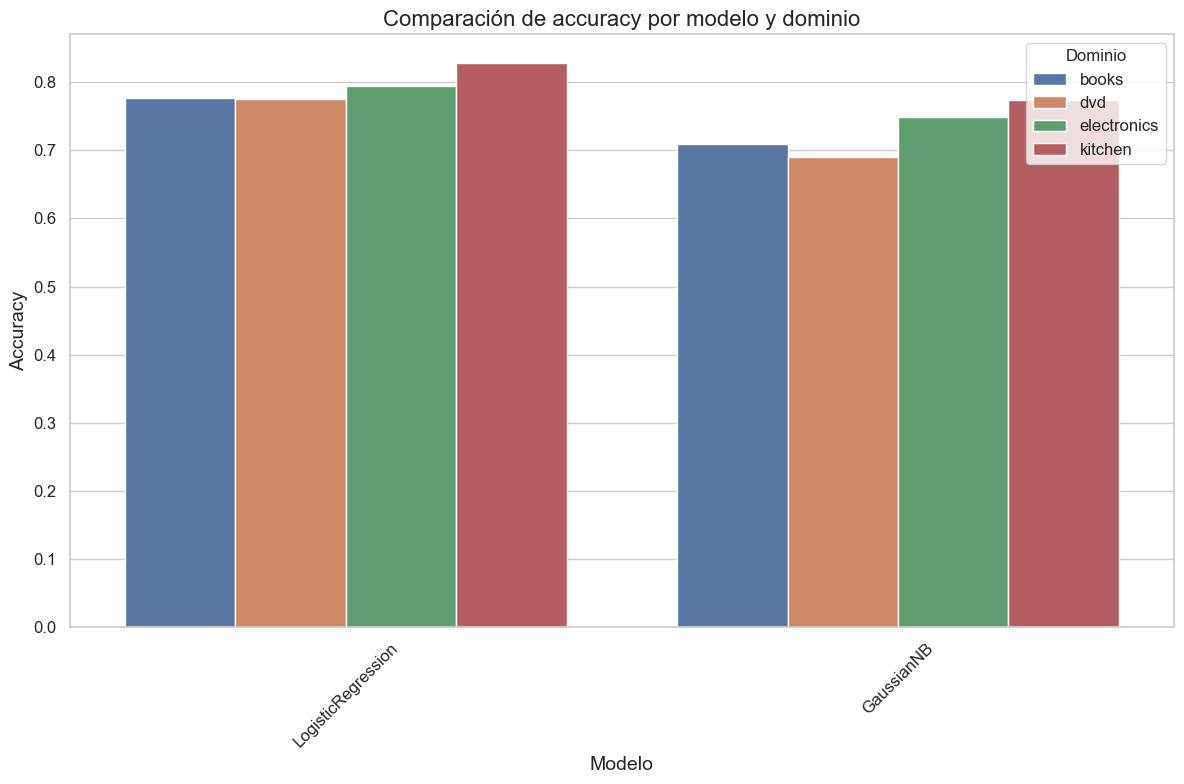

In [11]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

sns.barplot(data=domain_wise_evaluation, x="model", y="Accuracy", hue="domain", errorbar=None)

plt.title("Comparación de accuracy por modelo y dominio", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Modelo", fontsize=14)
plt.legend(title="Dominio", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

Presentamos una gráfica comparativa del *accuracy* para cada dominio, dependiendo de su vectorizador (*feature representation*). En general, con excepción de una muy leve diferencia para el dominio de *kitchen*, la mejor representación es TF-IDF.

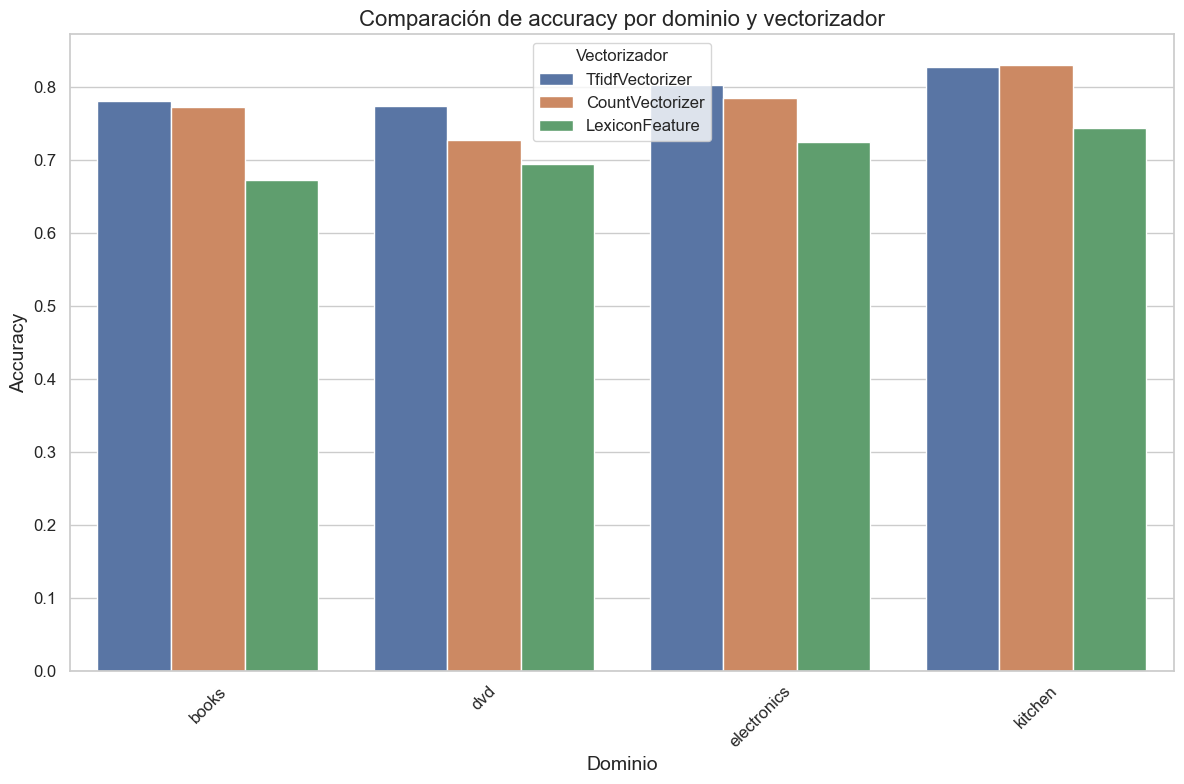

In [8]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

sns.barplot(data=domain_wise_evaluation, x="domain", y="Accuracy", hue="vectorizer", errorbar=None)

plt.title("Comparación de accuracy por dominio y vectorizador", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Dominio", fontsize=14)
plt.legend(title="Vectorizador", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


Para determinar cuál es el dominio más difícil de clasificar, vamos a agrupar los datos por dominio y promediar sus *accuracies*. Vemos que en general, y antes en las gráficas también que *dvd* posee los peores resultados.

In [9]:
domain_accuracy = domain_wise_evaluation.groupby('domain')['Accuracy'].mean().reset_index()
domain_accuracy = domain_accuracy.sort_values(by='Accuracy')
print(domain_accuracy)


        domain  Accuracy
1          dvd  0.732571
0        books  0.742703
2  electronics  0.771372
3      kitchen  0.801149


A continuación imprimimos el top de 10 características más importantes para todos los modelos de regresión logística.

In [12]:
def display_top_features_sorted_by_abs(feature_importances_df, top_n=10):
    """
    Imrpime las N características principales para cada combinación de dominio, modelo y vectorizador, 
    ordenadas por su importancia (valores absolutos de los coeficientes).
    
    Args:
        feature_importances_df (pd.DataFrame): el dataframe con los coeficientes de las características.
        top_n (int): número de características a mostrar.
    """
    grouped = feature_importances_df.groupby(['domain', 'model', 'vectorizer'])
    
    for (domain, model, vectorizer), group in grouped:
        print(f"Dominio: {domain}, Modelo: {model}, Veztorizador: {vectorizer}")
        
        # Ordenar por el valor absoluto del coeficiente, extrayendo las N características principales
        top_features = group.reindex(group['coefficient'].abs().sort_values(ascending=False).index)[:top_n]
        
        print("Top Características:")
        print(top_features[['feature', 'coefficient']].to_string(index=False))
        print('-' * 60)

display_top_features_sorted_by_abs(feature_importance_df, top_n=10)

Dominio: books, Modelo: LogisticRegression, Veztorizador: CountVectorizer
Top Características:
       feature  coefficient
   truth_hurts     0.050099
      year_the     0.050091
substance_only    -0.044373
       book_no    -0.044009
   sandford_is     0.043152
  a_mastermind     0.043152
        boring    -0.042232
       fast_it     0.040952
         waste    -0.039833
         hurts     0.039401
------------------------------------------------------------
Dominio: books, Modelo: LogisticRegression, Veztorizador: LexiconFeature
Top Características:
         feature  coefficient
   avg_neg_score    -0.846357
   avg_pos_score     0.506453
   max_neg_score    -0.422176
   max_pos_score     0.395021
  pos_word_count    -0.128886
  neg_word_count     0.121750
     score_ratio    -0.064951
score_difference     0.017714
 total_neg_score    -0.004177
 total_pos_score     0.002039
------------------------------------------------------------
Dominio: books, Modelo: LogisticRegression, Veztori

1. **Count Vectorizer:**  captura solo la frecuencia de aparición de palabras sencillas o compuestas. Las features más importantes suelen ser términos muy específicos y frecuentes dentro del dominio. 
    - En *books*, se destacan palabras o frases como "boring" y "waste", lo que indica que el análisis está fuertemente ligado a expresiones comunes y negativas que suelen aparecer en las reseñas.
    - En *dvd* y *electronics*, términos como "awfull_film" y "waste" están asociados con reseñas negativas, mientras que "great" y "price" se asocian con reseñas positivas.
    - En *kitchen*, términos positivos como "great" y "easy_to" se destacan, mientras que las reseñas negativas están marcadas por palabras como "disappointed".

2. **TF-IDF:** captura la relevancia de las palabras al reducir la importancia de aquellas que aparecen con demasiada frecuencia en todos los documentos, favoreciendo las que son más distintivas.
    - En *books*, términos como "excellent" y "great" tienen un peso positivo, mientras que palabras negativas como "waste" y "boring" tienen un peso negativo.
    - En *dvd*, "love" y "great" son los términos más representativos de reseñas positivas, mientras que "waste" y "boring" se destacan en reseñas negativas.
    - En *electronics* y *kitchen*, términos como "great", "easy", y "love" aparecen fuertemente asociados a reseñas positivas, mientras que "waste", "not", y "disappointed" indican reseñas negativas.

3. **Lexicon based features:** se basa en puntuaciones predefinidas de palabras según un léxico de sentimiento, en este caso SentiWordNet.
    - En todos los dominios, la "avg_neg_score" y "neg_word_count" tienen una alta influencia en reseñas negativas, lo que resalta cómo este vectorizador mide las cargas emocionales negativas.
    - Características como "score_ratio" y "avg_pos_score" reflejan el balance entre palabras positivas y negativas, afectando la puntuación global de la reseña.

## II. Solo un clasificador para todos los dominios

Ahora, consolidaremos todos los dominios en un solo dataset de entrenamiento y validación, y crearemos clasificadores para estos datos consolidados. La función `get_consolidated_data` recibe la ruta con todos los dominios y los junta. La función `evaluate_consolidated` llama a nuestras funciones definidas previamente sobre este dataset completo.

In [13]:
def get_consolidated_data(domains_path: Path):
    """
    Consolida datos de entrenamiento y testeo de todos los dominios en un único conjunto de datos.
    
    Args:
        domains_path (Path): Ruta al directorio que contiene las subcarpetas de cada dominio.
                             Cada subcarpeta debe contener archivos de datos de testeo y entrenamiento.
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Una tupla que contiene los conjuntos de datos de entrenamiento 
        y prueba consolidados.
    """
    all_train_dfs = []
    all_test_dfs = []
    
    # # Obtener la lista de carpetas de dominio (subdirectorios dentro de domains_path)
    domain_folders = [folder for folder in domains_path.iterdir() if folder.is_dir()]
    
    # Iterar sobre cada carpeta de dominio y cargar los datos de entrenamiento y testeo
    for domain_folder in domain_folders:
        train_df, val_df = load_domain(domain_folder)
        
        train_df['domain'] = domain_folder.name
        val_df['domain'] = domain_folder.name

        all_train_dfs.append(train_df)
        all_test_dfs.append(val_df)
    
    # Concatenar todos los dataframes de entrenamiento y testeo en conjuntos de datos consolidados
    consolidated_train_df = pd.concat(all_train_dfs, ignore_index=True)
    consolidated_test_df = pd.concat(all_test_dfs, ignore_index=True)
    
    return consolidated_train_df, consolidated_test_df

def evaluate_consolidated(domains_path: Path):
    """
    Consolida datos de todos los dominios, entrena un único modelo (dadas sus configuraciones) con los datos combinados
      y lo evalúa en el conjunto de prueba consolidado. Devuelve métricas de evaluación e importancias de características 
      para la regresión logística.
    
    Args:
        domains_path (Path): Ruta al directorio que contiene las subcarpetas de cada dominio.
                             Cada subcarpeta debe contener archivos de datos de testeo y entrenamiento.
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Una tupla que contiene un dataframe con resultados de evaluación y 
        un dataframe con importancias de características del modelo de regresión logística.
    """
    # Obtener los conjuntos de datos de testeo y entrenamiento consolidados
    consolidated_train_df, consolidated_test_df = get_consolidated_data(domains_path)
    
    # Evaluar el modelo utilizando el conjunto de datos consolidado, y devuelve los resultados y la importancia de las características.
    results_df, feature_importances_list = evaluate_over_dataset(consolidated_train_df, consolidated_test_df)
    
    # Combine las importancias de las características en un único dataframe
    if feature_importances_list:
        feature_importances_df = pd.concat(feature_importances_list, ignore_index=True)
    else:
        feature_importances_df = pd.DataFrame()
    
    return results_df, feature_importances_df

In [14]:
domains_path = Path('data/Multi Domain Sentiment/processed_acl/')
single_model_evaluation, feature_importance_df_single = evaluate_consolidated(domains_path)

Training and evaluating: 100%|██████████| 6/6 [00:50<00:00,  8.38s/it]


In [15]:
single_model_evaluation

,vectorizer,model,Precision (Macro),Recall (Macro),F1 Score (Macro),Precision (Micro),Recall (Micro),F1 Score (Micro),Accuracy
0,TfidfVectorizer,LogisticRegression,0.865639,0.865260,0.865279,0.865325,0.865325,0.865325,0.865325
1,CountVectorizer,LogisticRegression,0.836632,0.829382,0.828720,0.829700,0.829700,0.829700,0.829700
2,LexiconFeature,LogisticRegression,0.724705,0.724682,0.724650,0.724653,0.724653,0.724653,0.724653
3,TfidfVectorizer,GaussianNB,0.805309,0.804128,0.803820,0.803984,0.803984,0.803984,0.803984
4,CountVectorizer,GaussianNB,0.802169,0.800738,0.800371,0.800579,0.800579,0.800579,0.800579
5,LexiconFeature,GaussianNB,0.726617,0.709560,0.703548,0.708950,0.708950,0.708950,0.708950


Nuevamente podemos observar que la regresión logística se comporta mejor y obtiene mejores resultados en comparación a naive bayes.

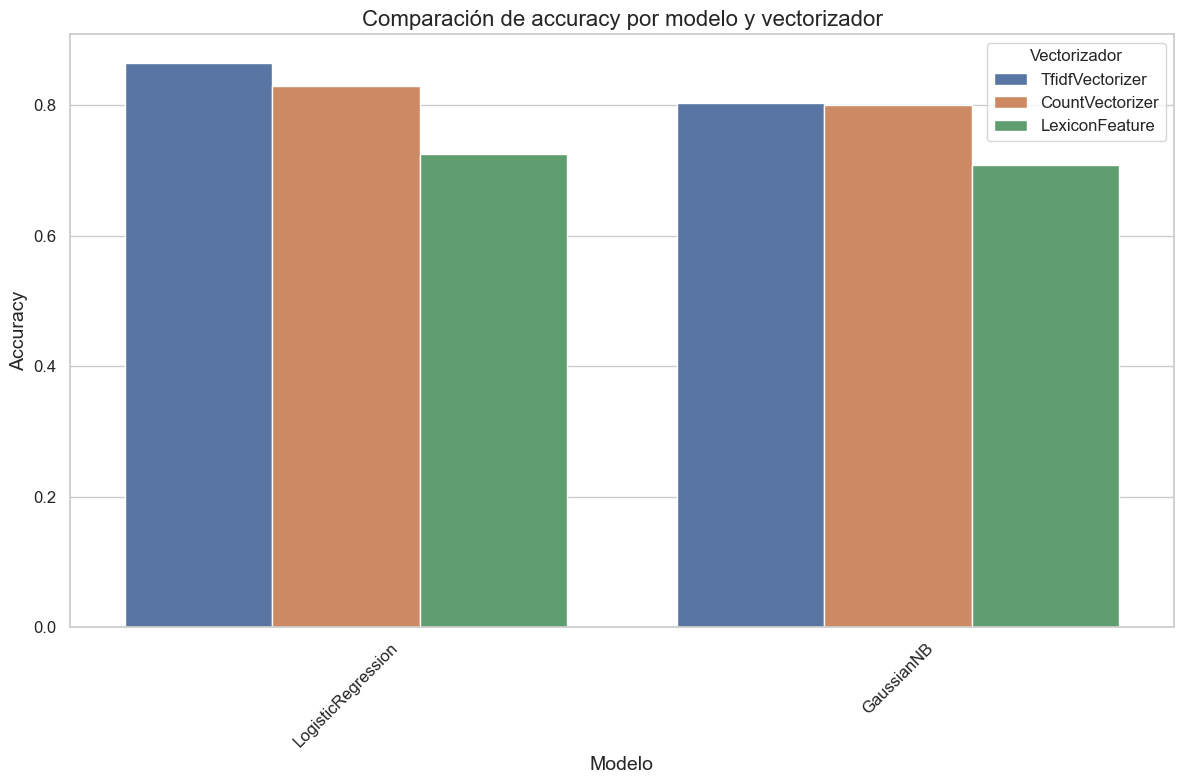

In [17]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

sns.barplot(data=single_model_evaluation, x="model", y="Accuracy", hue="vectorizer", errorbar=None)

plt.title("Comparación de accuracy por modelo y vectorizador", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Modelo", fontsize=14)
plt.legend(title="Vectorizador", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

In [16]:
def display_top_features_sorted_by_abs_no_domains(feature_importances_df, top_n=10):
    """
    Imprime las N características principales ordenadas por los valores absolutos de los coeficientes.
    
    Args:
        feature_importances_df (pd.DataFrame): el dataframe con los coeficientes de las características.
        top_n (int): número de características a mostrar.
    """
    if feature_importances_df.empty:
        print("No hay coeficientes disponibles.")
        return
    
    grouped = feature_importances_df.groupby(['model', 'vectorizer'])
    
    for (model, vectorizer), group in grouped:
        print(f"Modelo: {model}, Vectorizador: {vectorizer}")
    
        top_features = group.reindex(group['coefficient'].abs().sort_values(ascending=False).index)[:top_n]
        
        print("Top Características:")
        print(top_features[['feature', 'coefficient']].to_string(index=False))
        print('-' * 60)

display_top_features_sorted_by_abs_no_domains(feature_importance_df_single, top_n=10)

Modelo: LogisticRegression, Vectorizador: CountVectorizer
Top Características:
      feature  coefficient
        great     0.091130
        waste    -0.065679
     is_piece    -0.064885
          not    -0.061679
great_product     0.060227
     price_at     0.059272
    excellent     0.057559
      easy_to     0.056709
 product_have    -0.056265
 disappointed    -0.053534
------------------------------------------------------------
Modelo: LogisticRegression, Vectorizador: LexiconFeature
Top Características:
         feature  coefficient
  neg_word_count     0.698605
   avg_pos_score     0.675815
   avg_neg_score    -0.663171
   max_neg_score    -0.449298
  pos_word_count    -0.320348
score_difference     0.282753
   max_pos_score     0.239986
 total_neg_score    -0.232262
 total_pos_score    -0.099935
     score_ratio    -0.093414
------------------------------------------------------------
Modelo: LogisticRegression, Vectorizador: TfidfVectorizer
Top Características:
     feature  c

1. **Count Vectorizer:** 
    - Términos como "great" y "excellent" tienen un coeficiente positivo, lo que sugiere que son características comunes en reseñas positivas.
    - Palabras como "waste", "not", y "disappointed" tienen coeficientes negativos, lo que indica que se utilizan comúnmente en reseñas negativas.

2. **TF-IDF:**
    - Palabras como "great", "excellent", y "easy" reciben coeficientes positivos significativos.
    - Nuevamente, términos negativos como "waste", "not", y "disappointed" tienen coeficientes negativos.

3. **Lexicon based features:**
    - El "neg_word_count" (cantidad de palabras negativas) tiene el coeficiente más alto, lo que indica que las reseñas con más palabras negativas tienen una mayor influencia en la predicción negativa del modelo.
    - La "avg_pos_score" (puntuación promedio de palabras positivas) también es una característica importante, lo que implica que las reseñas con mayor promedio positivo tienen un impacto significativo en las predicciones.
    - Las métricas como "score_difference" (diferencia de puntajes) y "total_neg_score" muestran cómo se pondera el sentimiento de una reseña de manera general.

En comparación con las características importantes obtenidas en el literal anterior, podemos destacar:

- En los clasificadores por dominio, por ejemplo en **Count Vectorizer**, capturan términos muy específicos que son relevantes solo para ese contexto:
    - En *books*, por ejemplo, términos como "truth_hurts", "sandford_is", y "book_no" reflejan un vocabulario relacionado con reseñas literarias.
    - En *dvd*, frases como "awfull_film", "elmo_" y "tale_well" son términos típicos de reseñas de películas o entretenimiento.
    - En *electronics*, palabras como "price", "waste", y "not_work" reflejan preocupaciones específicas de ese dominio, como el costo y la funcionalidad del producto.

- Los clasificadores consolidades muestran características más generales. Términos como "great", "waste", "not", y "excellent" aparecen entre las principales características, las cuales son aplicables a múltiples dominios (libros, DVD, electrónicos, etc.)

**¿Vale la pena entrenar un clasificador por dominio?**

Lo que identificamos es que el clasificador consolidado alcanza un accuracy mayor (0.865) en comparación con la mayoría de los obtenidos para los dominios especificos, que son:

- *books*: 0.839
- *dvd*: 0.827
- *electronics*: 0.854
- *kitchen*: 0.875

Solo el clasificador para *kitchen* es 1 punto porcentual superior, pero no supone una mejora significativa.